# 5_inference.ipynb
Categorizes diseases for posts from r/AskDocs.

In [197]:
import pandas as pd
import numpy as np
from pprint import pprint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

input_data_folder = 'data_combination'
combined_data_file = input_data_folder + '/' + 'Combined.csv'

application_data_folder = 'data_application'
application_data_file = application_data_folder + '/' + 'AskDocs.csv'
application_output_csv_file = application_data_folder + '/' + 'Result.csv'

model_folder = 'model'

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [175]:
df = pd.read_csv(combined_data_file)
print(df.shape)

(43771, 17)


In [228]:
X = (df['Title'] + ' ' + df['Body']).values
# pprint(X)

X= X.astype(str)
# pprint(X)
print(X.shape)

(43771,)


In [178]:
X_test = X.copy()

In [227]:
df_application = pd.read_csv(application_data_file)
X_application = (df_application['Title'] + ' ' + df_application['Body']).values
X_application = X_application.astype(str)
print(X_application.shape)

(3045,)


In [229]:
y = df.iloc[:,10:].values
print(y.shape)
pprint(y)

(43771, 7)
array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])


In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)
pprint(y_test)

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])


In [231]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=22)
pprint(y_validate)

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])


In [232]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)

In [233]:
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/91240
num_words=9000
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed
pprint(tokenizer.word_index)

{'\r': 5368,
 "'": 4343,
 "'s": 7369,
 '0': 690,
 '00': 2128,
 '000': 3030,
 '00am': 7990,
 '01': 4687,
 '02': 6536,
 '03': 4251,
 '04': 5350,
 '05': 3824,
 '06': 5101,
 '07': 4349,
 '08': 4631,
 '09': 5818,
 '1': 138,
 "1's": 8868,
 '10': 272,
 '100': 491,
 '1000': 3373,
 '1000mg': 3693,
 '100mg': 4549,
 '101': 2552,
 '102': 3327,
 '103': 4148,
 '104': 6697,
 '105': 4928,
 '106': 8959,
 '10am': 5718,
 '10g': 7874,
 '10mg': 3791,
 '10pm': 6346,
 '10th': 3453,
 '10x': 6593,
 '11': 827,
 '110': 3369,
 '111': 6709,
 '115': 5579,
 '117': 8478,
 '11am': 8327,
 '11pm': 6376,
 '11th': 3930,
 '12': 550,
 '120': 2302,
 '122': 8939,
 '125': 4638,
 '128': 8519,
 '12pm': 8168,
 '12th': 4368,
 '13': 1053,
 '130': 2825,
 '135': 6021,
 '13th': 3991,
 '14': 666,
 '140': 2653,
 '145': 6319,
 '14th': 3690,
 '15': 539,
 '150': 1830,
 '1500': 6570,
 '150mg': 4582,
 '15mg': 6284,
 '15th': 3819,
 '16': 932,
 '160': 3255,
 '165': 7227,
 '16th': 3976,
 '17': 1135,
 '170': 4306,
 '175': 8524,
 '17th': 3493,
 '

 'channel': 5001,
 'chaos': 8389,
 'chapped': 6422,
 'chapter': 6937,
 'character': 7046,
 'charge': 4404,
 'charging': 6515,
 'charity': 6576,
 'chart': 4209,
 'charts': 5890,
 'chat': 2995,
 'chatting': 8042,
 'cheap': 2683,
 'cheaper': 4427,
 'cheat': 2962,
 'cheated': 2717,
 'cheating': 3565,
 'check': 501,
 'checked': 606,
 'checking': 1651,
 'checks': 3947,
 'checkup': 2759,
 'checkups': 5894,
 'cheek': 3934,
 'cheeks': 2584,
 'cheer': 7280,
 'cheers': 3285,
 'cheese': 2030,
 'chek': 6440,
 'chemical': 3315,
 'chemicals': 3987,
 'chemo': 318,
 'chemotherapy': 1231,
 'cherry': 8456,
 'chest': 182,
 'chew': 3498,
 'chewable': 7126,
 'chewed': 7249,
 'chewing': 3078,
 'chicago': 8161,
 'chick': 8346,
 'chicken': 1370,
 'child': 1312,
 'childhood': 2429,
 'children': 1607,
 "children's": 7937,
 'chill': 5459,
 'chills': 1030,
 'chin': 2993,
 'china': 5671,
 'chinese': 3786,
 'chip': 7058,
 'chips': 3380,
 'chlamidya': 7616,
 'chlamydia': 422,
 'chlorine': 7423,
 'chocolate': 1633,
 '

 'fading': 5343,
 'fail': 3385,
 'failed': 2310,
 'failing': 3555,
 'fails': 6022,
 'failure': 2631,
 'faint': 2925,
 'fainted': 7557,
 'fainting': 6549,
 'fair': 2548,
 'fairly': 1267,
 'faith': 3867,
 'faithful': 7737,
 'fake': 4848,
 'fall': 1118,
 'fallen': 5235,
 'falling': 1872,
 'falls': 4579,
 'false': 1113,
 'fam': 7170,
 'familiar': 2241,
 'families': 3841,
 'family': 289,
 'famotidine': 1963,
 'famous': 8360,
 'fan': 3753,
 'fancy': 6302,
 'fantastic': 4509,
 'far': 387,
 'farm': 8222,
 'fart': 7964,
 'farther': 7158,
 'farting': 8148,
 'farts': 8943,
 'farxiga': 7652,
 'fashion': 7700,
 'fast': 482,
 'fasted': 8277,
 'faster': 2361,
 'fasting': 952,
 'fat': 1238,
 'fatal': 7773,
 'fate': 6344,
 'father': 729,
 "father's": 5928,
 'fathers': 6986,
 'fatigue': 486,
 'fatigued': 1729,
 'fats': 3953,
 'fatty': 2313,
 'fault': 2804,
 'faulty': 7878,
 'favor': 5965,
 'favorite': 2289,
 'favourite': 6258,
 'fb': 7149,
 'fbclid': 6731,
 'fda': 4196,
 'fear': 876,
 'feared': 6588,
 '

 'lysol': 8335,
 'm': 1011,
 'mac': 6979,
 'machine': 2896,
 'machines': 6701,
 'macula': 8033,
 'macular': 4432,
 'mad': 1885,
 'maddening': 7979,
 'made': 282,
 'magic': 4089,
 'magical': 7959,
 'magically': 8532,
 'magnesium': 2519,
 'mail': 3273,
 'mailto': 4644,
 'main': 974,
 'mainly': 1239,
 'maintain': 2245,
 'maintained': 5415,
 'maintaining': 4283,
 'maintenance': 3955,
 'major': 944,
 'majority': 2730,
 'majorly': 7303,
 'make': 189,
 'makes': 356,
 'makeup': 2028,
 'making': 465,
 'malaise': 4816,
 'male': 551,
 'males': 6828,
 'malignant': 3741,
 'mall': 7008,
 'mama': 8418,
 'mammogram': 4861,
 'man': 1050,
 'manage': 965,
 'manageable': 2444,
 'managed': 1365,
 'management': 2045,
 'manager': 4381,
 'managing': 1833,
 'mandatory': 7658,
 'manifest': 7080,
 'manner': 5957,
 'manometry': 2724,
 'manual': 4607,
 'manually': 6105,
 'manufacturer': 7379,
 'manuka': 6391,
 'many': 299,
 'marathon': 4606,
 'march': 532,
 'margins': 7505,
 'marijuana': 3446,
 'mark': 2279,
 'mar

 'religious': 5488,
 'religiously': 4337,
 'reluctant': 4470,
 'rely': 3869,
 'relying': 5692,
 'remain': 2524,
 'remainder': 7503,
 'remained': 2750,
 'remaining': 3813,
 'remains': 3744,
 'remarkable': 8465,
 'remdesivir': 8981,
 'remedies': 1584,
 'remedy': 3162,
 'remember': 562,
 'remembered': 4274,
 'remembering': 5259,
 'remind': 4872,
 'reminded': 6388,
 'reminder': 4999,
 'reminders': 8894,
 'reminding': 8839,
 'reminds': 6494,
 'remission': 1576,
 'remote': 5145,
 'remotely': 4550,
 'removal': 2664,
 'remove': 1324,
 'removed': 910,
 'remover': 8113,
 'removing': 3013,
 'renal': 5364,
 'rent': 4837,
 'reoccurrence': 7650,
 'reoccurring': 5495,
 'reopening': 8236,
 'rep': 5806,
 'repair': 2490,
 'repaired': 7913,
 'repeat': 3148,
 'repeated': 4874,
 'repeatedly': 4279,
 'repeating': 6224,
 'repetitive': 8758,
 'replace': 3396,
 'replaced': 3732,
 'replacement': 3475,
 'replacing': 6246,
 'replied': 5819,
 'replies': 4126,
 'reply': 4167,
 'report': 1844,
 'reported': 3718,
 'r

 'tumor': 814,
 'tumors': 1804,
 'tumour': 2638,
 'tumours': 5440,
 'tums': 1383,
 'tuna': 7135,
 'tune': 8546,
 'tunnel': 3656,
 'turkey': 2512,
 'turmeric': 5853,
 'turn': 979,
 'turned': 916,
 'turning': 2385,
 'turns': 1310,
 'tv': 2561,
 'twenties': 5557,
 'twenty': 6200,
 'twice': 528,
 'twin': 7602,
 'twist': 8711,
 'twitch': 5218,
 'twitches': 6725,
 'twitching': 3921,
 'twitter': 6913,
 'two': 149,
 'tx': 7833,
 'ty': 8819,
 'tylenol': 1681,
 'type': 220,
 'type1': 7507,
 'types': 1620,
 'typical': 1626,
 'typically': 1727,
 'typing': 3763,
 'u': 1338,
 'uber': 8668,
 'ugh': 3147,
 'ugly': 3479,
 'uh': 7758,
 'uk': 1022,
 'ulcer': 1722,
 'ulcerative': 7924,
 'ulcers': 2218,
 'ultimate': 7696,
 'ultimately': 3429,
 'ultra': 3267,
 'ultrasound': 1575,
 'ultrasounds': 6110,
 'un': 7464,
 'unable': 1268,
 'unaware': 4971,
 'unbearable': 2026,
 'unbearably': 8319,
 'unbelievable': 8416,
 'unbelievably': 7386,
 'uncertain': 5421,
 'uncertainty': 5630,
 'uncircumcised': 7388,
 'uncle

In [234]:
tokenizer.word_index[tokenizer.oov_token] = num_words + 1

In [235]:
X_test_0 = X_test.copy()
# pprint(X_test_0)

In [236]:
X_train = tokenizer.texts_to_sequences(X_train)
X_validate = tokenizer.texts_to_sequences(X_validate)
X_test = tokenizer.texts_to_sequences(X_test)

In [237]:
X_application = tokenizer.texts_to_sequences(X_application)

In [238]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
pprint(vocab_size)

9002


In [239]:
maxlen = 300
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_validate = pad_sequences(X_validate, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
pprint(X_train)

array([[ 469, 1244, 1637, ...,    0,    0,    0],
       [2137, 1085,  625, ...,    0,    0,    0],
       [ 123,  222,  634, ...,    0,    0,    0],
       ...,
       [3587, 4003,  156, ...,    0,    0,    0],
       [ 126, 1601,  850, ...,    0,    0,    0],
       [ 100,   56,    7, ...,    0,    0,    0]], dtype=int32)


In [243]:
X_application = pad_sequences(X_application, padding='post', maxlen=maxlen)
pprint(X_application)

array([[   2,  136,    8, ..., 4692,  839,  159],
       [ 126, 3921,  278, ...,    0,    0,    0],
       [ 125,    1,   25, ...,    0,    0,    0],
       ...,
       [  99,  243,   17, ...,  505,   59,   34],
       [  11,   72, 1602, ...,    0,    0,    0],
       [ 416,  923,  237, ...,    0,    0,    0]], dtype=int32)


In [244]:
input_dim = X_train.shape[1] 
pprint(input_dim)

300


In [245]:
# https://nlp.stanford.edu/projects/glove/
embedding_dim = 300
embedding_matrix = create_embedding_matrix('embedding/glove.6B.300d.txt', tokenizer.word_index, embedding_dim)
pprint(embedding_matrix)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13292   ,  0.16985001, -0.1436    , ..., -0.23778   ,
         0.14766   ,  0.62901998],
       [ 0.038466  , -0.039792  ,  0.082747  , ..., -0.33427   ,
         0.011807  ,  0.059703  ],
       ...,
       [-0.097744  ,  0.31358999,  0.19789   , ..., -0.10354   ,
        -0.039862  ,  0.22826   ],
       [ 0.0013958 ,  0.18329   ,  0.10296   , ..., -0.15792   ,
        -0.24106   ,  0.1972    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])


In [246]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
embedding_accuracy = nonzero_elements / vocab_size
print('embedding accuracy: ' + str(embedding_accuracy))
print(nonzero_elements)
print(vocab_size)

embedding accuracy: 0.9486780715396579
8540
9002


In [247]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(7, activation='sigmoid'))
opt = optimizers.Adam(lr=0.0002)

In [248]:
model.compile(optimizer=opt, loss='binary_crossentropy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          2700600   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 298, 256)          230656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 298, 256)          0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 2,933,055
Trainable params: 2,933,055
Non-trainable params: 0
_________________________________________________________________


In [219]:
new_model = load_model(model_folder + '/' + 'best_model.h5')
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          2700600   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 298, 256)          230656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 298, 256)          0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 2,933,055
Trainable params: 2,933,055
Non-trainable params: 0
_________________________________________________________________


In [249]:
pprint(X_test.shape)

(4378, 300)


In [250]:
y_pred = new_model.predict(X_test)
pprint(y_pred[:100])

array([[9.99467611e-01, 1.22155249e-02, 2.27645796e-05, 8.31076431e-06,
        1.19855074e-04, 1.94470249e-05, 1.11691807e-05],
       [5.37157059e-04, 7.12484121e-04, 2.75039673e-03, 4.03791666e-04,
        1.89158320e-03, 1.95673108e-03, 9.99952912e-01],
       [1.10250711e-03, 3.99290890e-01, 2.41720676e-03, 7.65556097e-01,
        2.64316797e-04, 6.72315955e-02, 1.14627481e-02],
       [2.36176602e-05, 3.31484007e-05, 1.32322311e-04, 1.88469887e-04,
        2.05553970e-05, 4.92542586e-06, 9.99999642e-01],
       [9.99994159e-01, 3.05831432e-04, 2.31469203e-05, 5.83077554e-06,
        3.16647711e-05, 2.95630821e-06, 1.80733005e-05],
       [4.64886427e-04, 8.24350715e-01, 1.98660564e-05, 1.72597629e-05,
        4.15561626e-05, 2.68921558e-05, 4.47035581e-01],
       [6.39945269e-04, 1.69456005e-04, 6.13768876e-01, 3.78343463e-03,
        2.07114208e-05, 3.56098790e-05, 6.92814589e-04],
       [8.20398331e-04, 9.99784827e-01, 1.99705362e-04, 6.50942326e-04,
        1.73121691e-04, 3

In [251]:
application_pred = new_model.predict(X_application)
pprint(application_pred[:100])

array([[6.21587038e-04, 3.25265199e-01, 5.32597303e-04, 8.23751034e-05,
        4.81468439e-03, 2.18958676e-01, 1.04136765e-02],
       [2.26809382e-02, 2.44800150e-02, 1.24443144e-01, 2.90071070e-02,
        3.87337506e-02, 8.51780176e-04, 1.86413527e-04],
       [3.68714333e-04, 9.85343933e-01, 9.73552465e-04, 1.79380178e-04,
        7.34090805e-04, 4.85836267e-02, 5.93811274e-04],
       [2.53617764e-04, 1.78921163e-01, 9.51515436e-02, 4.95836139e-03,
        2.86206603e-03, 5.23528457e-03, 1.31968558e-02],
       [9.96370077e-01, 3.75926495e-04, 3.44645123e-05, 8.26394444e-06,
        2.35339999e-03, 1.07591450e-02, 1.44240021e-05],
       [5.64777851e-03, 9.22722340e-01, 7.16508627e-02, 2.87184119e-03,
        6.66701794e-03, 2.91481614e-03, 9.26542853e-05],
       [2.51096487e-03, 9.47360873e-01, 1.87137723e-03, 6.13033772e-04,
        4.57495451e-04, 8.54758109e-05, 6.00016415e-02],
       [8.52833390e-02, 5.23766875e-01, 7.61988759e-03, 3.35270166e-03,
        3.33622396e-02, 9

In [252]:
thresholds=[0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Threshold: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(val, precision, recall, f1))

Threshold: 0.1000, Precision: 0.9019, Recall: 0.9831, F1-measure: 0.9408
Threshold: 0.2000, Precision: 0.9396, Recall: 0.9742, F1-measure: 0.9566
Threshold: 0.2500, Precision: 0.9492, Recall: 0.9692, F1-measure: 0.9591
Threshold: 0.3000, Precision: 0.9576, Recall: 0.9646, F1-measure: 0.9611
Threshold: 0.4000, Precision: 0.9666, Recall: 0.9571, F1-measure: 0.9618
Threshold: 0.5000, Precision: 0.9766, Recall: 0.9518, F1-measure: 0.9640
Threshold: 0.6000, Precision: 0.9810, Recall: 0.9440, F1-measure: 0.9622
Threshold: 0.7000, Precision: 0.9846, Recall: 0.9354, F1-measure: 0.9594
Threshold: 0.8000, Precision: 0.9890, Recall: 0.9246, F1-measure: 0.9557
Threshold: 0.9000, Precision: 0.9925, Recall: 0.9029, F1-measure: 0.9456


In [254]:
column_names = list(df.columns[10:])
f1_scores = []
threshold = 0.4
for i in range(0, 7):
    disease_prediction = y_pred[:,i]
    disease_prediction[disease_prediction>=threshold]=1
    disease_prediction[disease_prediction<threshold]=0
    disease_test = y_test[:,i]
    precision = precision_score(disease_test, disease_prediction)
    recall = recall_score(disease_test, disease_prediction)
    f1 = f1_score(disease_test, disease_prediction)
    f1_scores.append(f1)
    print("Disease: {}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(column_names[i], precision, recall, f1))

Disease: cancer, Precision: 0.9630, Recall: 0.9418, F1-measure: 0.9523
Disease: COVID19positive, Precision: 0.9223, Recall: 0.9441, F1-measure: 0.9330
Disease: diabetes, Precision: 0.9713, Recall: 0.9611, F1-measure: 0.9661
Disease: eczema, Precision: 0.9679, Recall: 0.9563, F1-measure: 0.9621
Disease: eyetriage, Precision: 0.9502, Recall: 0.9745, F1-measure: 0.9622
Disease: GERD, Precision: 0.9769, Recall: 0.9658, F1-measure: 0.9713
Disease: STD, Precision: 0.9864, Recall: 0.9587, F1-measure: 0.9723


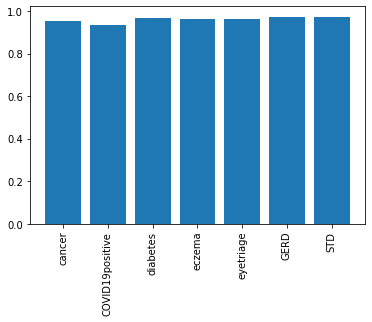

In [255]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(column_names,f1_scores)
plt.xticks(rotation=90)
plt.show()

In [256]:
print(df_application.shape)

(3045, 8)


In [257]:
application_test = pd.concat([df_application, pd.DataFrame(application_pred)], axis=1, sort=False)
# Note: for the combined one, needs to turn on header
application_test.to_csv(application_output_csv_file, index=None, header=True)